In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import sys
import os
import re
%matplotlib inline

<a id='0'></a>
# Outline

## [1.1 CSV Processing](#1.1)
- Extract raw data
- Remove space between data

## [1.2 Create Dateframe](#1.2)
- Drop null rows and column
- Covert columns into proper data types
- Assinge station code to station
- Create "Origin-Destination" column
- Datetime process

## [2.0 Create Dateframe for Visialization](#2.0)
- Extract data based on weekday and average them, output as a list.
- Combine all weekday list into a table

## [3.0 Visualization using Heatmap](#3.0)
- Create a figure with 2 frames, 1 for inward data and the other for outward, for each station

<a id='1.1'></a>
## [1.1 CSV Processing](#0)
- Extract raw data
- Remove space between data

In [2]:


#extract raw data
def csv_extracter(file_name):
    extract_list = []
    count = 1
    with open('{}'.format(file_name), encoding="utf8") as csvfile:  
        # read CSV 
        rows = csv.reader(csvfile)
        # extract rows
        for row in rows:
            if count%10000 == 0:
                sys.stdout.write('\rextracting row {}'.format(count))
            extract_list.append(row)
            count += 1
    sys.stdout.write('\nextracting finished\n')     
    return extract_list

#remove spacing
def csv_cleaner(extract_list):
    cleaned = []
    count = 1
    for item in extract_list:
        if count%10000 == 0:
            sys.stdout.write('\rcleaning row {}'.format(count))
        new_row = []
        for row in item:
            new_row = ','.join(row.split())
            new_row = new_row.split(',')

        cleaned.append(new_row)
        count += 1
    sys.stdout.write('\ncleaning finished\n')
    return cleaned

In [3]:
extracted = csv_extracter('raw_data.csv')
extracted[:10]

extracting row 7590000
extracting finished


[['\ufeff日期         時段     進站                             出站                             人次'],
 ['---------- ------ ------------------------------ ------------------------------ -----------'],
 ['2018-07-01 00     松山機場                           松山機場                           0'],
 ['2018-07-01 00     松山機場                           中山國中                           0'],
 ['2018-07-01 00     松山機場                           南京復興                           0'],
 ['2018-07-01 00     松山機場                           忠孝復興                           0'],
 ['2018-07-01 00     松山機場                           大安                             1'],
 ['2018-07-01 00     松山機場                           科技大樓                           0'],
 ['2018-07-01 00     松山機場                           六張犁                            1'],
 ['2018-07-01 00     松山機場                           麟光                             0']]

In [4]:
cleaned = csv_cleaner(extracted)
cleaned[:10]

cleaning row 7590000
cleaning finished


[['\ufeff日期', '時段', '進站', '出站', '人次'],
 ['----------',
  '------',
  '------------------------------',
  '------------------------------',
  '-----------'],
 ['2018-07-01', '00', '松山機場', '松山機場', '0'],
 ['2018-07-01', '00', '松山機場', '中山國中', '0'],
 ['2018-07-01', '00', '松山機場', '南京復興', '0'],
 ['2018-07-01', '00', '松山機場', '忠孝復興', '0'],
 ['2018-07-01', '00', '松山機場', '大安', '1'],
 ['2018-07-01', '00', '松山機場', '科技大樓', '0'],
 ['2018-07-01', '00', '松山機場', '六張犁', '1'],
 ['2018-07-01', '00', '松山機場', '麟光', '0']]

In [5]:
##Station ID
#Reference for station code and name
def station_ID():
    #file_ID = 'station_id.csv'
    file_ID = 'station_id2.csv'
    with open(file_ID, 'r', encoding="utf-8") as fid:
        stationlist = csv.reader(fid)
        id_dict = {rows[1]:rows[0] for rows in stationlist}
    return id_dict

def station_eng_name():
    file_ID = 'station_name.csv'
    with open(file_ID, 'r', encoding="utf-8") as fid:
        stationlist = csv.reader(fid)
        id_dict = {rows[0]:rows[3] for rows in stationlist}
    return id_dict

<a id='1.2'></a>
## [1.2 Create Dateframe](#0)
- Drop null rows and column
- Covert columns into proper data types
- Assinge station code to station
- Create "Origin-Destination" column
- Datetime process

In [6]:

def raw_to_df(cleaned,id_dict):
    #cleaning raw data
    print('processing raw data...')
    df = pd.DataFrame(cleaned)
    #drop null column: cloumn 5
    df = df[[0,1,2,3,4]]

    #fix headers, drop "----"
    df = df.drop([0,1])
    df.columns = ['date', 'time', 'entrance', 'exit', 'people']

    #drop null rows
    df = df[df['people'] != 'Null']

    #converting to proper dtypes in order to save memories.
    print('converting raw dtypes...')
    df = df[df['time'].str.contains('[0-9]', na=False, regex=True) == True]
    df["time"] = df["time"].astype('int8')
    df["people"] = pd.to_numeric(df["people"], downcast='integer')
    df["entrance"] = df["entrance"].astype('category')
    df["exit"] = df["exit"].astype('category')

    #get code_id of stations from "station_id2.csv"
    print('adding station IDs...')
    df['code_entrance'] = df['entrance'].map(id_dict)
    df['code_exit'] = df['exit'].map(id_dict)

    df["code_entrance"] = df["code_entrance"].astype('category')
    df["code_exit"] = df["code_exit"].astype('category')
    
    #Create "Origin-Destination" column
    df['from_to'] = df['entrance'].str.cat(df['exit'],sep='_')
    df['from_to'] = df['from_to'].astype('category')

    #processing datetime, weeknum and weekday
    print('processing datetime, weeknum and weekday...')
    df['date'] = pd.to_datetime(df['date'],errors='coerce')
    df['weekday'] = df['date'].dt.weekday
    df["weekday"] = pd.to_numeric(df["weekday"], downcast='integer')
    df['weeknum'] = df['date'].dt.week
    df["weeknum"] = pd.to_numeric(df["weeknum"], downcast='integer')

    print('raw DataFrame DONE\n')
    return df

id_dict = station_ID()
df = raw_to_df(cleaned, id_dict)
df.head()

processing raw data...
converting raw dtypes...
adding station IDs...
processing datetime, weeknum and weekday...
raw DataFrame DONE



,date,time,entrance,exit,people,code_entrance,code_exit,from_to,weekday,weeknum
2,2018-07-01,0,松山機場,松山機場,0,BR13,BR13,松山機場_松山機場,6,26
3,2018-07-01,0,松山機場,中山國中,0,BR13,BR12,松山機場_中山國中,6,26
4,2018-07-01,0,松山機場,南京復興,0,BR13,G16,松山機場_南京復興,6,26
5,2018-07-01,0,松山機場,忠孝復興,0,BR13,BL15,松山機場_忠孝復興,6,26
6,2018-07-01,0,松山機場,大安,1,BR13,R05,松山機場_大安,6,26


<a id='2.0'></a>
## [2.0 Create Dateframe for Visialization](#0)
- Extract data based on weekday and average them, output as a list.
- Combine all weekday list into a table

In [7]:

def df_to_pivot(df):
    pv = df.pivot_table(index=['date','from_to'], columns='time', values='people')
    return pv

#extracting certain weekday data from a given station from cleaned dataframe 
#weekday input is based on weekday variable given by pandas
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.dt.weekday.html
def weekday_series(df,weekday,station,output,by_thousand):
    if output == 'out':
        df_weekday = df[(df['weekday'] == weekday) & (df['code_exit'] == station)].copy()
    elif output == 'in':
        df_weekday = df[(df['weekday'] == weekday) & (df['code_entrance'] == station)].copy()

    pv_weekday = df_to_pivot(df_weekday).dropna()
    weekday_count = len(pv_weekday.index.get_level_values(0).unique())
    if by_thousand == True:
        result_weekday = round(pv_weekday.sum(numeric_only=True)/weekday_count/1000,1)
    else:
        result_weekday = pv_weekday.sum(numeric_only=True)/weekday_count
   
    return result_weekday

#extracting weekday data from a given station from dataframe 
def station_sum_up(df,station,output,by_thousand):
    sys.stdout.write('\rprocessing {}, output format: {}'.format(station, output))
    weekday_list = []
    for i in range(7):
        series = weekday_series(df,i,station,output,by_thousand)
        weekday_list.append(series)
    #.T is for matric transpose
    result = pd.concat(weekday_list, axis=1).T

    result['weekday'] = ['Mon','Tue','Wed','Thu','Fri','Sat','Sun']
    result = result.set_index('weekday')
    
    return result

#get max value in a table(for heatmap legend and station_table_to_list)
# get maximum value in a dataframe creaed from station_sum_up
def get_df_max(df):
    max_value = 0
    for item in df.columns:
        if df[item].max() > max_value:
            max_value = df[item].max()
    return max_value

In [8]:
#output example of 2 functions above: using station code BL12 inward data as an example
print('weekday_series: ',weekday_series(df,0,"BL12","in",True),'\n')

print('station_sum_up:')
station_sum_up(df,"BL12","in",True)

weekday_series:  time
0      1.3
1      0.0
5      0.0
6      1.3
7      5.3
8     13.8
9      9.4
10     7.2
11     7.1
12     8.1
13     8.7
14     8.2
15     7.9
16     8.5
17    12.1
18    15.3
19    11.7
20     9.0
21     9.1
22    10.7
23     3.4
dtype: float64 

station_sum_up:
processing BL12, output format: in

time,0,1,5,6,7,8,9,10,11,12,...,14,15,16,17,18,19,20,21,22,23
weekday,,,,,,,,,,,,,,,,,,,,,
Mon,1.3,0.0,0.0,1.3,5.3,13.8,9.4,7.2,7.1,8.1,...,8.2,7.9,8.5,12.1,15.3,11.7,9.0,9.1,10.7,3.4
Tue,1.0,0.0,0.0,1.1,4.8,12.6,8.8,6.4,6.4,7.6,...,7.8,7.7,9.4,12.7,14.2,10.2,7.6,7.5,8.8,2.7
Wed,1.3,0.0,0.0,0.9,3.8,10.4,7.3,5.8,5.9,7.1,...,7.8,7.7,8.3,11.9,14.6,11.0,8.4,8.8,10.2,3.1
Thu,1.3,0.0,0.0,1.1,4.8,12.5,9.0,7.0,6.8,8.0,...,8.4,8.0,8.7,12.5,15.9,11.9,9.1,9.8,10.8,3.2
Fri,2.0,0.0,0.0,1.1,4.8,12.3,9.2,7.2,7.5,8.5,...,9.2,9.2,9.9,14.2,17.7,14.5,11.1,11.7,14.0,5.0
Sat,1.9,0.0,0.0,1.0,3.0,6.2,7.9,9.8,11.3,12.3,...,12.5,12.1,12.7,15.6,14.7,11.4,10.2,10.7,12.4,4.6
Sun,1.9,0.0,0.0,0.7,2.0,4.3,6.0,8.2,9.4,10.4,...,11.0,11.7,12.3,14.8,14.8,12.7,12.3,12.9,11.7,5.6


<a id='3.0'></a>
## [3.0 Visualization using Heatmap](#0)
- Create a figure with 2 frames, 1 for inward data and the other for outward, for each station

In [9]:
def heat_map(station_data1,station_name1,station_data2,station_name2):
    f, (ax1,ax2) = plt.subplots(1,2,figsize = (18, 5))
      
    vmax1 = get_df_max(station_data1)
    vmax2 = get_df_max(station_data2)
    if vmax1 > vmax2:
        vmax_label = vmax1
    else:
        vmax_label = vmax2
    
    cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
    heatmap = sns.heatmap(station_data1, ax=ax1,center=None,
                          cmap='Blues',
                          vmin= 0,
                          vmax= vmax_label,
                          annot=True)
    ax1.set_title('{} (by thousand)'.format(station_name1),y=1.1)
    ax1.xaxis.tick_top()
    ax1.set_xlabel('Time of Day')

       
    cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
    heatmap = sns.heatmap(station_data2, ax=ax2,center=None,
                          cmap='Reds',
                          vmin= 0,
                          vmax= vmax_label,
                          annot=True)
    ax2.set_title('{} (by thousand)'.format(station_name2),y=1.1)
    ax2.xaxis.tick_top()
    ax2.set_xlabel('Time of Day')

    plt.tight_layout()
    #plt.savefig(station_name1.split()[0])
    
#For testing your regex is selecting what you want.
def station_filter_test(pattern):
    # ex: 'BL12':'Taipei Train Station'
    station_dict = station_eng_name()
    output_station = {}
    for k,v in station_dict.items():
        if re.search(pattern,k) is not None:
            print(k,v)
            
#heatmap bulk output
def heatmap_bulk_processing(df,pattern):
    #1 SELECTING STATIONS TO BE PROCESSED
    station_dict = station_eng_name()
    output_station = {}
    # ex: 'BL12':'Taipei Train Station'
    for k,v in station_dict.items():
        if re.search(pattern,k) is not None:
            output_station[k] =v
    #2 COVERTING RAW DATA INTO TABLE IN CORRECT FORMAT
    output_table = {}
    for k,v in output_station.items():
        table_list = []
        table_in = station_sum_up(df,k,'in',True)
        table_out = station_sum_up(df,k,'out',True)
        table_list.extend((table_in,table_out))
        output_table[k] = table_list
    
    print('\nheatmap_bulk_processing DONE')
    return output_table

def heatmap_bulk_presenting(output_table):
    station_dict = station_eng_name()
    for k,v in output_table.items():
        heat_map(output_table[k][0],'{} {} IN'.format(k,station_dict[k]),
                 output_table[k][1],'{} {} OUT'.format(k,station_dict[k]))



In [10]:
#Select part of blue lines using '^BL1'
pattern = '^BL1'
station_filter_test(pattern)

BL19 Yongchun
BL18 Taipei City Hall
BL17 Sun Yat-Sen Memorial Hall
BL16 Zhongxiao Dunhua
BL15 Zhongxiao Fuxing
BL14 Zhongxiao Xinsheng
BL13 Shandao Temple
BL12 Taipei Main Station
BL11 Ximen
BL10 Longshan Temple


In [11]:
blue_line = heatmap_bulk_processing(df,pattern)
#Where the first dataframe is inward flow, while second one is outward.
blue_line['BL12']

processing BL10, output format: out
heatmap_bulk_processing DONE


[time      0    1    5    6    7     8    9    10    11    12 ...     14    15  \
 weekday                                                      ...                
 Mon      1.3  0.0  0.0  1.3  5.3  13.8  9.4  7.2   7.1   8.1 ...    8.2   7.9   
 Tue      1.0  0.0  0.0  1.1  4.8  12.6  8.8  6.4   6.4   7.6 ...    7.8   7.7   
 Wed      1.3  0.0  0.0  0.9  3.8  10.4  7.3  5.8   5.9   7.1 ...    7.8   7.7   
 Thu      1.3  0.0  0.0  1.1  4.8  12.5  9.0  7.0   6.8   8.0 ...    8.4   8.0   
 Fri      2.0  0.0  0.0  1.1  4.8  12.3  9.2  7.2   7.5   8.5 ...    9.2   9.2   
 Sat      1.9  0.0  0.0  1.0  3.0   6.2  7.9  9.8  11.3  12.3 ...   12.5  12.1   
 Sun      1.9  0.0  0.0  0.7  2.0   4.3  6.0  8.2   9.4  10.4 ...   11.0  11.7   
 
 time       16    17    18    19    20    21    22   23  
 weekday                                                 
 Mon       8.5  12.1  15.3  11.7   9.0   9.1  10.7  3.4  
 Tue       9.4  12.7  14.2  10.2   7.6   7.5   8.8  2.7  
 Wed       8.3  11.9  14.6  

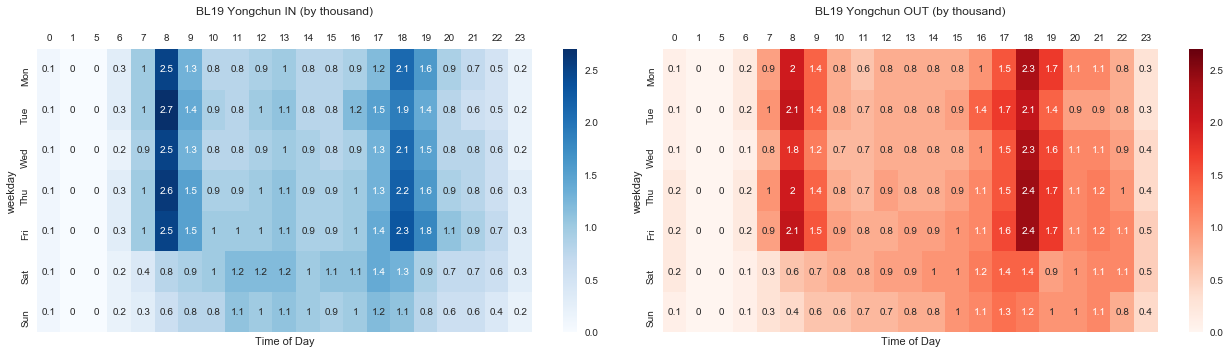

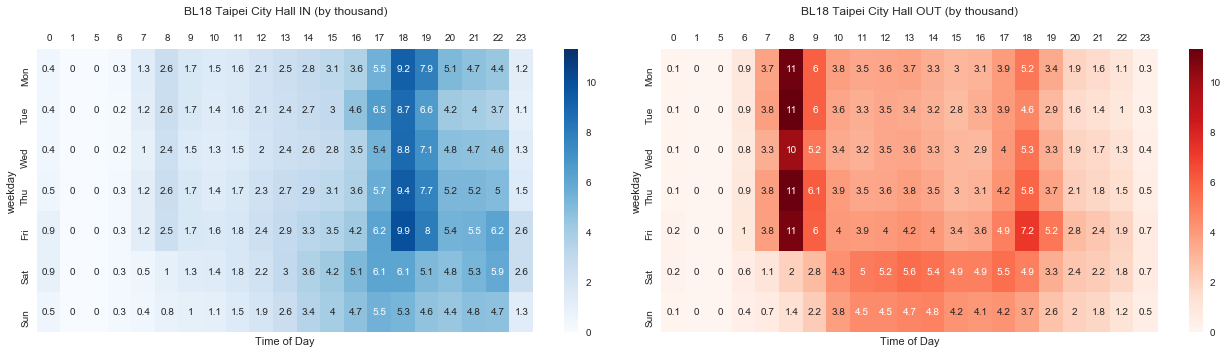

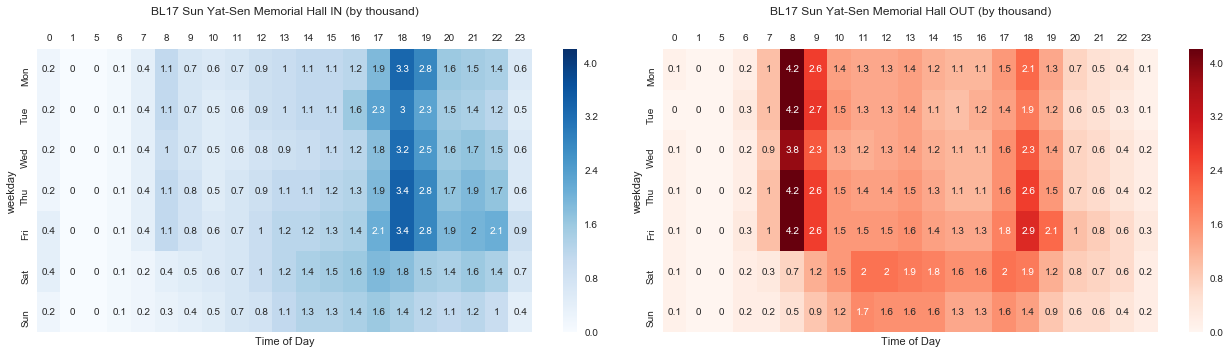

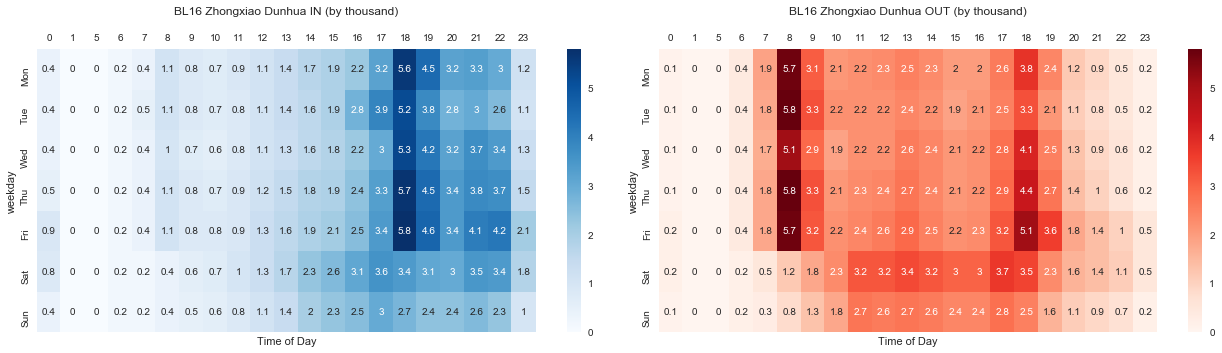

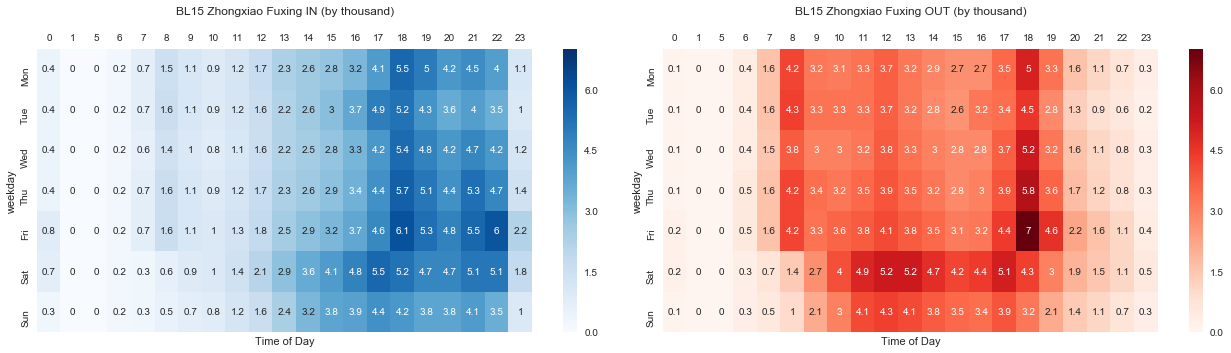

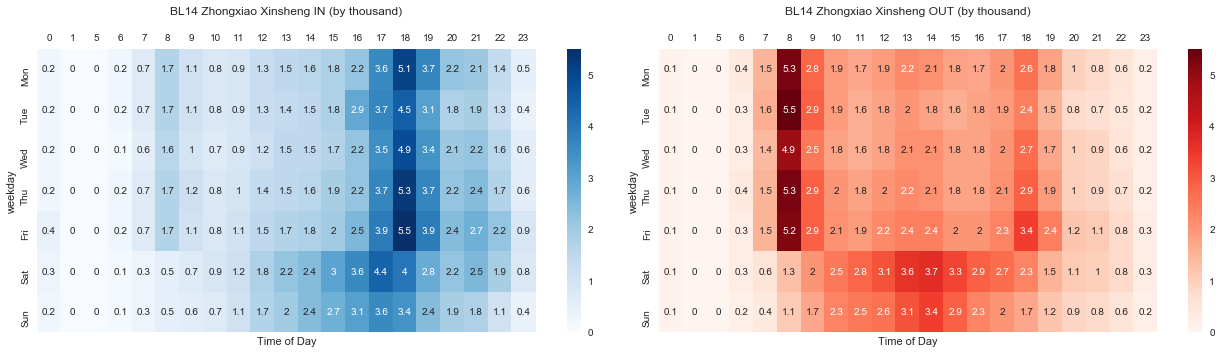

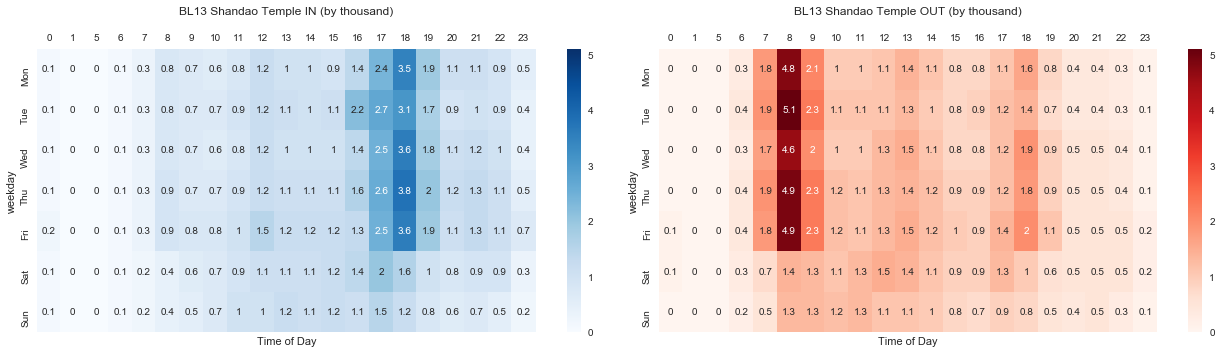

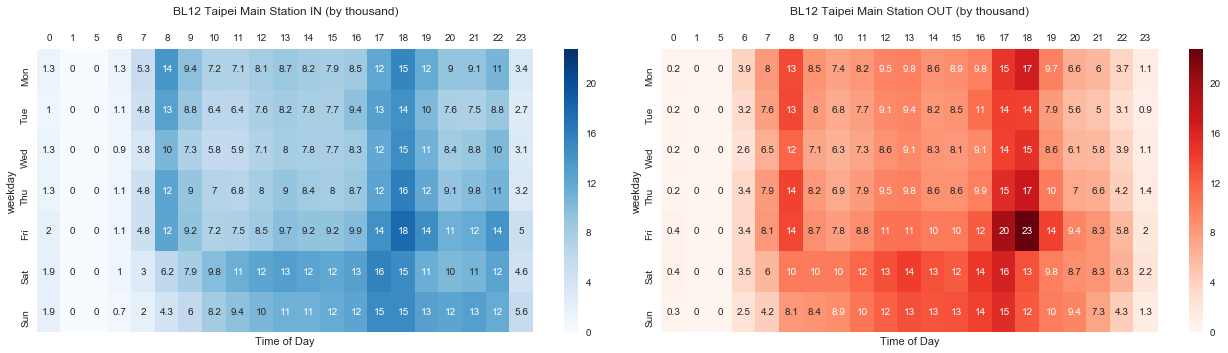

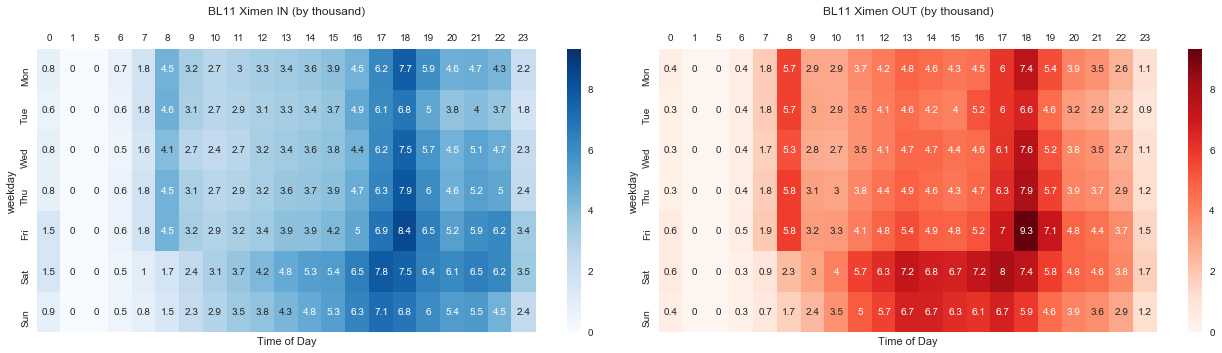

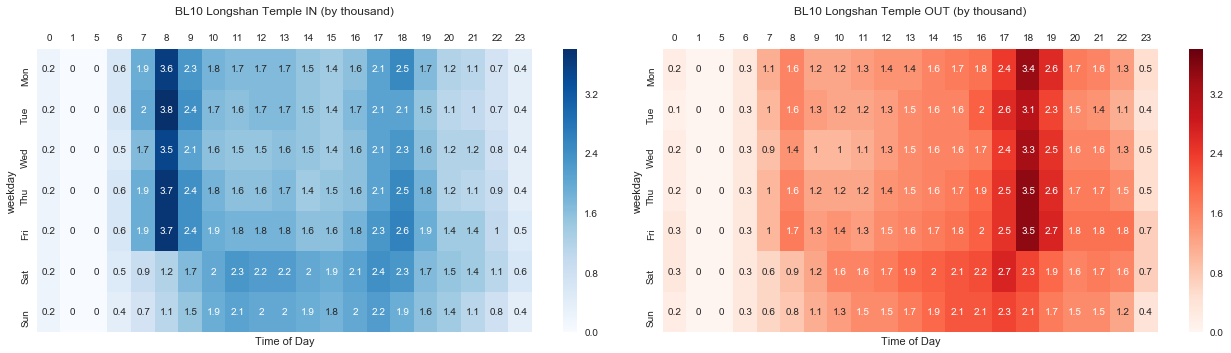

In [12]:
heatmap_bulk_presenting(blue_line)

In [13]:
#3.0 All processes in 1 

def csv_to_df(file_name):
    print('processing {}\n'.format(file_name))
    extracted_list = csv_extracter(file_name)
    cleaned = csv_cleaner(extracted_list)
    id_dict = station_ID()
    df = raw_to_df(cleaned,id_dict)
    
    return df

#df = csv_to_df('raw_data.csv')
#blue_line = heatmap_bulk_processing(df,pattern)
#heatmap_bulk_presenting(blue_line)